In [23]:
import datetime as dt
import requests
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
from math import floor
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [24]:

start=dt.datetime(2020,1,1)
end=dt.datetime(2021,7,8)
data=pdr.DataReader("GOOG","yahoo",start,end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,1338.000000,1329.084961,1330.109985,1337.020020,961800,1337.020020
2020-01-02,1368.140015,1341.550049,1341.550049,1367.369995,1406600,1367.369995
2020-01-03,1372.500000,1345.543945,1347.859985,1360.660034,1186400,1360.660034
2020-01-06,1396.500000,1350.000000,1350.000000,1394.209961,1732300,1394.209961
2020-01-07,1402.989990,1390.380005,1397.939941,1393.339966,1502700,1393.339966
...,...,...,...,...,...,...
2021-07-01,2529.250000,2496.995117,2496.995117,2527.370117,856000,2527.370117
2021-07-02,2576.959961,2535.379883,2536.790039,2574.379883,1058000,2574.379883
2021-07-06,2597.689941,2568.179932,2588.989990,2595.419922,1067500,2595.419922


In [25]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

data_macd = get_macd(data['Close'], 26, 12, 9)

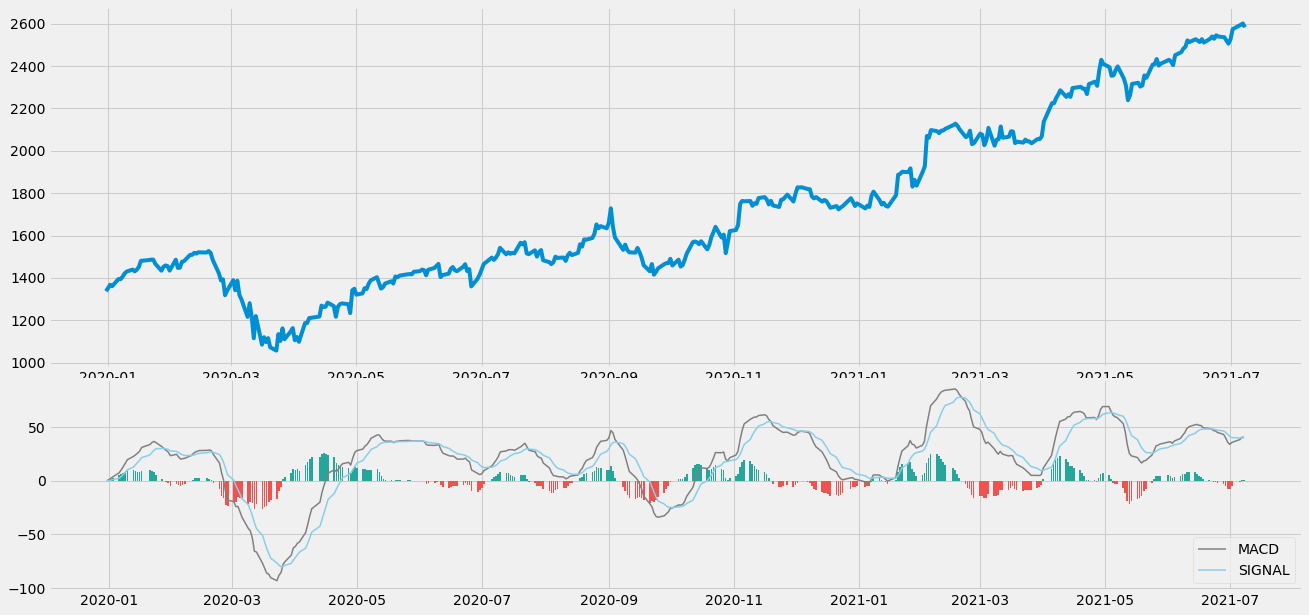

In [26]:

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(data['Close'], data_macd['macd'], data_macd['signal'], data_macd['hist'])

In [27]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(data['Close'], data_macd)

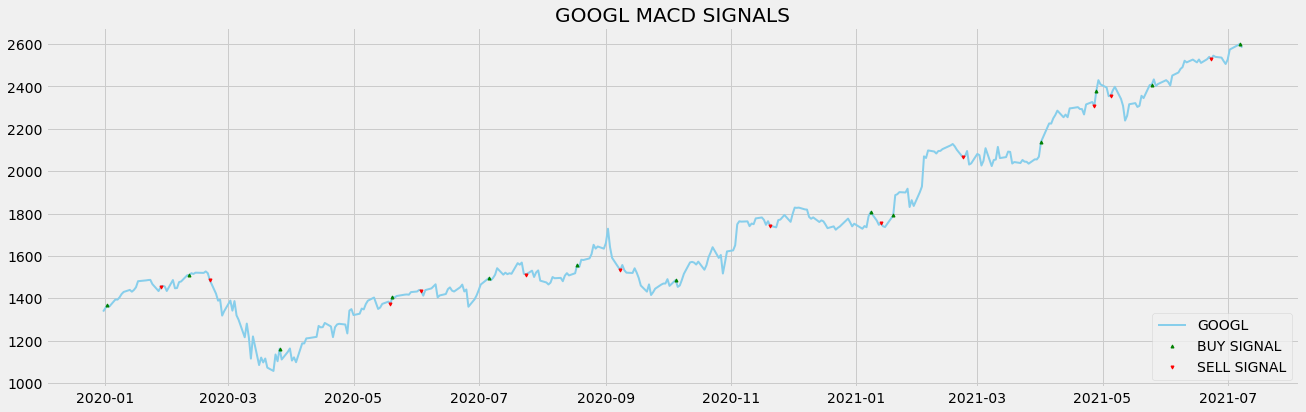

In [28]:

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
# ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['Close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 3, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 3, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
# # ax2.plot(data_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
# # ax2.plot(data_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

# for i in range(len(data_macd)):
#     if str(data_macd['hist'][i])[0] == '-':
#         ax2.bar(data_macd.index[i], data_macd['hist'][i], color = '#ef5350')
#     else:
#         ax2.bar(data_macd.index[i], data_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

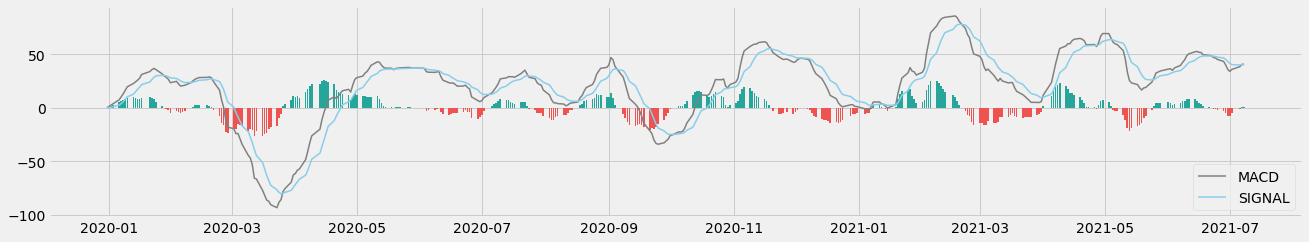

In [29]:
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)
ax2.plot(data_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(data_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
for i in range(len(data_macd)):
    if str(data_macd['hist'][i])[0] == '-':
        ax2.bar(data_macd.index[i], data_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(data_macd.index[i], data_macd['hist'][i], color = '#26a69a')
plt.legend(loc = 'lower right')
plt.show()

In [30]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = data_macd['macd']
signal = data_macd['signal']
close_price = data['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(data.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,macd,signal,macd_signal,macd_position
Date,,,,,
2019-12-31,1337.020020,0.000000,0.000000,0,1
2020-01-02,1367.369995,2.421081,0.484216,1,1
2020-01-03,1360.660034,3.755081,1.138389,0,1
2020-01-06,1394.209961,7.433792,2.397470,0,1
2020-01-07,1393.339966,10.161856,3.950347,0,1
...,...,...,...,...,...
2021-07-01,2527.370117,33.959577,41.457877,0,0
2021-07-02,2574.379883,35.793776,40.325057,0,0
2021-07-06,2595.419922,38.501328,39.960311,0,0


In [31]:

data_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(data_ret)):
    try:
        returns = data_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/data['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print('Profit gained from the MACD strategy by investing ${} in GOOGL : ${}'.format(investment_value,total_investment_ret))
print('Profit percentage of the MACD strategy : {}%'.format(profit_percentage))

Profit gained from the MACD strategy by investing $100000 in GOOGL : $77621.94
Profit percentage of the MACD strategy : 77%


In [32]:

def get_benchmark(start_date, investment_value):
    spy = pdr.DataReader('goog',"yahoo", start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret))
print('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage))
print('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage))

Benchmark profit by investing $100k : 65991.72
Benchmark Profit percentage : 65%
MACD Strategy profit is 12% higher than the Benchmark Profit


In [33]:
spy = pdr.DataReader('SPY',"yahoo", '2020-01-01').loc[:,['Close','Open']]
spy

,Close,Open
Date,,
2019-12-31,321.859985,320.529999
2020-01-02,324.869995,323.540009
2020-01-03,322.410004,321.160004
2020-01-06,323.640015,320.489990
2020-01-07,322.730011,323.019989
...,...,...
2022-07-08,388.670013,387.269989
2022-07-11,384.230011,385.850006
2022-07-12,380.829987,383.649994


In [34]:
dataw=data['Close']
data['Signal']=macd_signal
data.drop(columns=['High','Low','Close','Open','Volume','Adj Close'])
data

,High,Low,Open,Close,Volume,Adj Close,Signal
Date,,,,,,,
2019-12-31,1338.000000,1329.084961,1330.109985,1337.020020,961800,1337.020020,0
2020-01-02,1368.140015,1341.550049,1341.550049,1367.369995,1406600,1367.369995,1
2020-01-03,1372.500000,1345.543945,1347.859985,1360.660034,1186400,1360.660034,0
2020-01-06,1396.500000,1350.000000,1350.000000,1394.209961,1732300,1394.209961,0
2020-01-07,1402.989990,1390.380005,1397.939941,1393.339966,1502700,1393.339966,0
...,...,...,...,...,...,...,...
2021-07-01,2529.250000,2496.995117,2496.995117,2527.370117,856000,2527.370117,0
2021-07-02,2576.959961,2535.379883,2536.790039,2574.379883,1058000,2574.379883,0
2021-07-06,2597.689941,2568.179932,2588.989990,2595.419922,1067500,2595.419922,0


In [17]:
data_macd

,macd,signal,hist
Date,,,
2019-12-31,0.000000,0.000000,0.000000
2020-01-02,2.421081,0.484216,1.936865
2020-01-03,3.755081,1.138389,2.616692
2020-01-06,7.433792,2.397470,5.036322
2020-01-07,10.161856,3.950347,6.211509
...,...,...,...
2021-07-01,33.959577,41.457877,-7.498300
2021-07-02,35.793776,40.325057,-4.531281
2021-07-06,38.501328,39.960311,-1.458983


In [16]:
signal

Date
2019-12-31     0.000000
2020-01-02     0.484216
2020-01-03     1.138389
2020-01-06     2.397470
2020-01-07     3.950347
                ...    
2021-07-01    41.457877
2021-07-02    40.325057
2021-07-06    39.960311
2021-07-07    40.102825
2021-07-08    40.177067
Name: signal, Length: 383, dtype: float64

In [35]:
macd_signal

,macd_signal
Date,
2019-12-31,0
2020-01-02,1
2020-01-03,0
2020-01-06,0
2020-01-07,0
...,...
2021-07-01,0
2021-07-02,0
2021-07-06,0
